# **SETTING UP ENVIRONMENT**

In [ ]:
!git clone https://github.com/pybox2d/pybox2d --quiet && cd pybox2d

In [ ]:
!python setup.py clean --quiet
!python setup.py build --quiet
!sudo python setup.py install --quiet
!apt-get install -y python-dev swig --quiet
!pip install -q swig
!pip install -q gymnasium[box2d]
# !pip install gym[box2d]


python3: can't open file '/content/setup.py': [Errno 2] No such file or directory
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory
Reading package lists...
Building dependency tree...
Reading state information...
Package python-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python2-dev python2 python-dev-is-python3

E: Package 'python-dev' has no installation candidate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

In [ ]:
def setup_environment(env_name, seed=42):
    try:
        env = gym.make(env_name)
        env.seed(seed)
        print(f"State Shape: {env.observation_space.shape}")
        print(f"Action Shape: {env.action_space.n}")
        return env
    except gym.error.UnregisteredEnv as e:
        print(f"Error: The environment '{env_name}' is not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

env = setup_environment('LunarLander-v2', 42)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


State Shape: (8,)
Action Shape: 4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


# **NEURAL NETWORK**

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
class DQNetwork(nn.Module):
  def __init__(self, num_state, num_action):
    super(DQNetwork, self).__init__()
    self.fc1 = nn.Linear(num_state, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, num_action)
    self.act1 = nn.LeakyReLU(inplace = True)
    self.act2 = nn.LeakyReLU(inplace = True)

  def forward(self, state):
    x = self.act1(self.fc1(state))
    x = self.act2(self.fc2(x))
    return self.fc3(x)

In [ ]:
# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **MEMORY MANAGEMENT**

In [ ]:
class memory_buffer:
  def __init__(self, buffer_size, batch_size):
    self.batch_size = batch_size
    self.replay_memory = deque(maxlen=buffer_size)
    self.experience_tuple = namedtuple("Experience", field_names = ["current_state", "action", "reward", "next_state", "done"])

  def update_memory(self, current_state, action, reward, next_state, done):
    mem = self.experience_tuple(current_state, action, reward, next_state, done)
    self.replay_memory.append(mem)

  def sample_memory(self):
    experiences = random.sample(self.replay_memory, k=self.batch_size)
    batch_size = len(experiences)
    current_states = np.empty((batch_size, *experiences[0].current_state.shape))
    actions = np.empty((batch_size, 1), dtype=np.int64)
    rewards = np.empty((batch_size, 1), dtype=np.float32)
    next_states = np.empty((batch_size, *experiences[0].next_state.shape))
    done_flag = np.empty((batch_size, 1), dtype=np.uint8)

    for i, experience in enumerate(experiences):
        current_states[i] = experience.current_state
        actions[i] = experience.action
        rewards[i] = experience.reward
        next_states[i] = experience.next_state
        done_flag[i] = experience.done

    current_states = torch.from_numpy(current_states).float().to(device)
    actions = torch.from_numpy(actions).long().to(device)
    rewards = torch.from_numpy(rewards).float().to(device)
    next_states = torch.from_numpy(next_states).float().to(device)
    done_flag = torch.from_numpy(done_flag).float().to(device)

    return (current_states, actions, rewards, next_states, done_flag)


  def __len__(self):
    return len(self.replay_memory)

# **AGENT**

In [ ]:
class Agent():
  def __init__(self, num_state, num_action, seed, lr):
    self.num_state = num_state
    self.num_action = num_action
    self.mem_buf = memory_buffer(int(1e5), 64)
    self.update_step = 0
    self.local_network = DQNetwork(num_state, num_action).to(device)
    self.target_network = DQNetwork(num_state, num_action).to(device)
    self.optimizer = optim.Adam(self.local_network.parameters(), lr = lr)
    self.criterion = nn.MSELoss()

  def update_weights(self, localf, targetf, tau):
    with torch.no_grad():
        for targetp, localp in zip(targetf.parameters(), localf.parameters()):
            targetp.data.copy_(tau * localp.data + (1.0 - tau) * targetp.data)

  def agent_learn(self, experiences, gamma):
    current_states, actions, rewards, next_states, done_flag = experiences

    with torch.no_grad():
        next_target = self.target_network(next_states).max(1)[0].unsqueeze(1)
        Q_target = rewards + gamma * next_target * (1 - done_flag)

    Q_expected = self.local_network(current_states).gather(1, actions)

    loss = self.criterion(Q_expected, Q_target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update_weights(self.local_network, self.target_network, tau=1e-3)

  def move(self, current_state, action, reward, state_next, done):
    self.mem_buf.update_memory(current_state, action, reward, state_next, done)
    self.update_step = (self.update_step + 1) % 4
    if self.update_step == 0:
      if len(self.mem_buf) > self.mem_buf.batch_size:
        experiences_sample = self.mem_buf.sample_memory()
        self.agent_learn(experiences_sample, gamma = 0.99)


  def agent_action(self, state, epsilon = 0.0):
    state = torch.from_numpy(state).float()
    state = state.unsqueeze(0).to(device)

    self.local_network.eval()
    with torch.no_grad():
      a_val = self.local_network(state)
    self.local_network.train()
    if random.random() > epsilon:
      return np.argmax(a_val.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.num_action))


# **GET SCORES**

In [ ]:
def get_scores(num_episodes=2000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decrement=0.995):
  scores_out = []
  n = num_episodes + 1
  epsilons = []
  score_window = deque(maxlen = 100)
  epsilon = epsilon_start

  for i in range(1, n):
    current_state = env.reset()
    score = 0

    for j in range(1000):
      action = agent.agent_action(current_state, epsilon)
      state_next, rewrd, done, info = env.step(action)
      agent.move(current_state, action, rewrd, state_next, done)
      current_state = state_next
      score += rewrd

      if done:
        break

    score_window.append(score)
    scores_out.append(score)
    epsilon = max(epsilon_end, epsilon_decrement * epsilon)
    epsilons.append(epsilon)
    average_score = np.mean(score_window)
    check_val = 200.0

    print('\rEpisode Number: {} \tAverage Score: {:.2f} \tEpsilon val: {:.2f}'.format(i, average_score, epsilon), end="")
    if i % 100 == 0:

            print('\rEpisode Number: {} \tAverage Score: {:.2f} \tEpsilon val: {:.2f}'.format(i, average_score, epsilon))

    if average_score >= check_val:

        print('\n It took {:d} episodes to solve with average score of : {:.2f}'.format(i-100, average_score))
        torch.save(agent.local_network.state_dict(), 'checkpoint.pth')
        break
  return scores_out, epsilons

agent = Agent(num_state = 8, num_action = 4, seed = 42, lr = 0.001)
scores, epsilons = get_scores()

Episode Number: 100 	Average Score: -128.58 	Epsilon val: 0.61
Episode Number: 200 	Average Score: -67.02 	Epsilon val: 0.37
Episode Number: 300 	Average Score: -35.24 	Epsilon val: 0.22
Episode Number: 400 	Average Score: 19.50 	Epsilon val: 0.13
Episode Number: 500 	Average Score: 138.18 	Epsilon val: 0.08
Episode Number: 600 	Average Score: 186.40 	Epsilon val: 0.05
Episode Number: 700 	Average Score: 178.14 	Epsilon val: 0.03
Episode Number: 728 	Average Score: 200.01 	Epsilon val: 0.03
 It took 628 episodes to solve with average score of : 200.01


# **PLOTS**

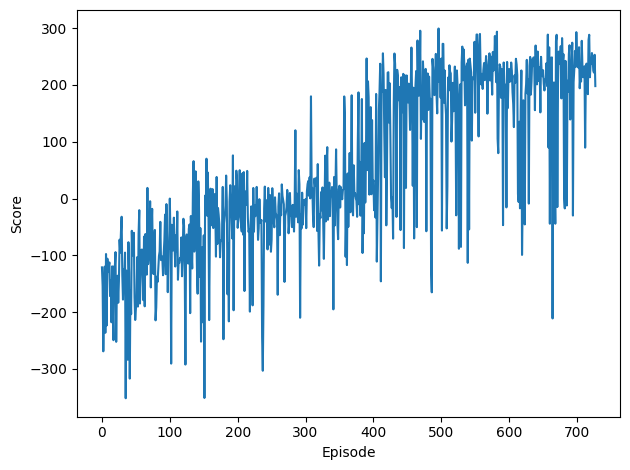

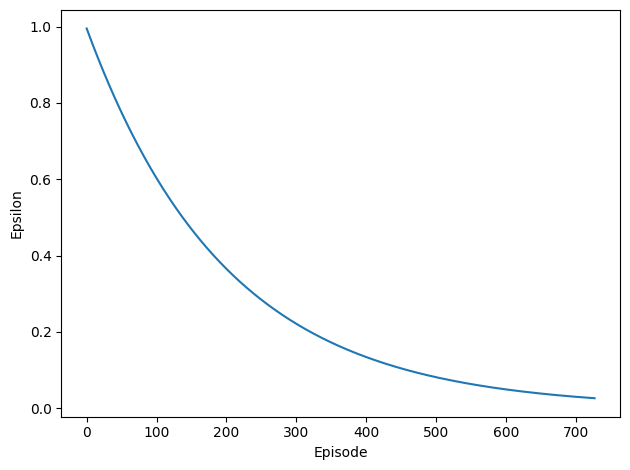

In [ ]:
fig1, axs1 = plt.subplots()
axs1.plot(np.arange(len(scores)), scores)
axs1.set(xlabel='Episode', ylabel='Score')
axs1.tick_params(axis='y')
fig1.tight_layout()
fig1.savefig('scores_plot.png')
plt.show()

fig2, axs2 = plt.subplots()
axs2.plot(np.arange(len(epsilons)), epsilons,)
axs2.set(xlabel='Episode', ylabel='Epsilon')
axs2.tick_params(axis='y')
fig2.tight_layout()
fig2.savefig('epsilon_plot.png')
plt.show()

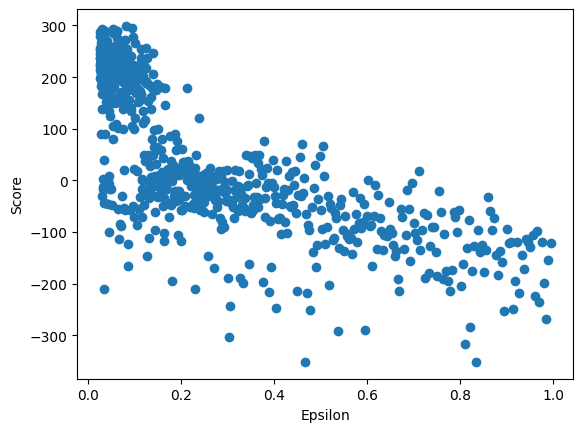

In [ ]:
plt.figure()
plt.scatter(epsilons, scores, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.savefig('score_vs_epsilon.png')
plt.show()

In [ ]:
# Reward per episode for 100 consecutive episodes using you trained agent and discussion of the results.
def test_agent(agent, env, n_episodes=100):
    checkpoint = torch.load('checkpoint.pth')
    agent.local_network.load_state_dict(checkpoint)

    scores = []
    for i in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.agent_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            state = next_state
            if done:
                break
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores)), end = "")
    return scores
agent = Agent(num_state=8, num_action=4, seed=42, lr = 0.001)
scores = test_agent(agent, env)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

In [ ]:
from gym.wrappers.monitoring import video_recorder
import os

In [ ]:
def display_model_video(agent, environment_name):

    os.makedirs('video_dir', exist_ok=True)

    env = gym.make(environment_name)
    video_rec = video_recorder.VideoRecorder(env, path="video_dir/{}.mp4".format(environment_name))
    loaded_model = torch.load('checkpoint.pth')
    agent.local_network.load_state_dict(loaded_model)
    initial_state = env.reset()
    termination_flag = False

    while not termination_flag:
        frame_image = env.render(mode='rgb_array')
        video_rec.capture_frame()
        selected_action = agent.agent_action(initial_state)
        initial_state, reward, termination_flag, _ = env.step(selected_action)

    video_rec.close()
    env.close()

trained_agent = Agent(num_state=8, num_action=4, seed=0, lr = 0.001)
display_model_video(trained_agent, 'LunarLander-v2')


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [ ]:
from IPython.display import HTML

HTML("""
    <video width="320" height="240" controls>
        <source src="/content/video_dir/LunarLander-v2.mp4" type="video/mp4">
    </video>
""")

# **Graphs**

In [ ]:
class Agent():
  def __init__(self, num_state, num_action, seed, lr, gamma, epsilon, tau):
    self.num_state = num_state
    self.num_action = num_action
    self.mem_buf = memory_buffer(int(1e5), 64)
    self.update_step = 0
    self.local_network = DQNetwork(num_state, num_action).to(device)
    self.target_network = DQNetwork(num_state, num_action).to(device)
    self.optimizer = optim.Adam(self.local_network.parameters(), lr = lr)
    self.criterion = nn.MSELoss()
    self.epsilon = epsilon

  def update_weights(self, localf, targetf, tau):
    with torch.no_grad():
        for targetp, localp in zip(targetf.parameters(), localf.parameters()):
            targetp.data.copy_(tau * localp.data + (1.0 - tau) * targetp.data)

  def agent_learn(self, experiences, gamma):
    current_states, actions, rewards, next_states, done_flag = experiences

    with torch.no_grad():
        next_target = self.target_network(next_states).max(1)[0].unsqueeze(1)
        Q_target = rewards + gamma * next_target * (1 - done_flag)

    Q_expected = self.local_network(current_states).gather(1, actions)

    loss = self.criterion(Q_expected, Q_target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update_weights(self.local_network, self.target_network, tau=tau)

  def move(self, current_state, action, reward, state_next, done):
    self.mem_buf.update_memory(current_state, action, reward, state_next, done)
    self.update_step = (self.update_step + 1) % 4
    if self.update_step == 0:
      if len(self.mem_buf) > self.mem_buf.batch_size:
        experiences_sample = self.mem_buf.sample_memory()
        self.agent_learn(experiences_sample, gamma = gamma)


  def agent_action(self, state):
    state = torch.from_numpy(state).float()
    state = state.unsqueeze(0).to(device)

    self.local_network.eval()
    with torch.no_grad():
      a_val = self.local_network(state)
    self.local_network.train()

    if random.random() > self.epsilon:
      return np.argmax(a_val.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.num_action))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_scores(agent, num_episodes=2000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decrement=0.995):
  scores_out = []
  n = num_episodes + 1
  epsilons = []
  score_window = deque(maxlen = 100)
  epsilon = epsilon_start

  for i in range(1, n):
    current_state = env.reset()
    score = 0

    for j in range(1000):
      action = agent.agent_action(current_state)
      state_next, rewrd, done, info = env.step(action)
      agent.move(current_state, action, rewrd, state_next, done)
      current_state = state_next
      score += rewrd
      if done:
        break

    score_window.append(score)
    scores_out.append(score)
    epsilon = max(epsilon_end, epsilon_decrement * epsilon)
    epsilons.append(epsilon)
    average_score = np.mean(score_window)
    check_val = 200.0

    print('\rEpisode Number: {} \tAverage Score: {:.2f} \tEpsilon val: {:.2f}'.format(i, average_score, epsilon), end="")
    if i % 100 == 0:

            print('\rEpisode Number: {} \tAverage Score: {:.2f} \tEpsilon val: {:.2f}'.format(i, average_score, epsilon))

    if average_score >= check_val:

        print('\n It took {:d} episodes to solve with average score of : {:.2f}'.format(i-100, average_score))
        torch.save(agent.local_network.state_dict(), 'checkpoint.pth')
        break
  return scores, epsilons

# **EXPERIMENTING WITH HYPERPARAMETERS**

In [ ]:
# GAMMA VALUES

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')
gamma_values = [0.8, 0.9, 0.95, 0.99, 0.999]
num_state = 8
num_action = 4
seed = 42
lr = 0.001
tau = 0.001
for gamma in gamma_values:
  agent = Agent(num_state, num_action, seed, lr, gamma=gamma, epsilon= 0.1,  tau = tau)
  scores, _ = get_scores(agent)
  scores_smooth = moving_average(scores)
  plt.plot(scores, label=f'Gamma: {gamma}')

plt.ylabel('Smoothed Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

Episode Number: 100 	Average Score: -192.55 	Epsilon val: 0.61
Episode Number: 200 	Average Score: -112.39 	Epsilon val: 0.37
Episode Number: 300 	Average Score: -87.35 	Epsilon val: 0.22
Episode Number: 400 	Average Score: 2.11 	Epsilon val: 0.13
Episode Number: 500 	Average Score: -11.07 	Epsilon val: 0.08
Episode Number: 600 	Average Score: -19.52 	Epsilon val: 0.05
Episode Number: 700 	Average Score: 36.21 	Epsilon val: 0.03
Episode Number: 800 	Average Score: 6.62 	Epsilon val: 0.02
Episode Number: 900 	Average Score: 31.36 	Epsilon val: 0.01
Episode Number: 1000 	Average Score: 26.53 	Epsilon val: 0.01
Episode Number: 1100 	Average Score: 22.30 	Epsilon val: 0.01
Episode Number: 1200 	Average Score: 30.39 	Epsilon val: 0.01
Episode Number: 1300 	Average Score: 40.53 	Epsilon val: 0.01
Episode Number: 1400 	Average Score: 56.55 	Epsilon val: 0.01
Episode Number: 1500 	Average Score: 38.27 	Epsilon val: 0.01
Episode Number: 1600 	Average Score: 32.03 	Epsilon val: 0.01
Episode Numb

In [ ]:
# EPSILON VALUES

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

epsilon_values = [0.1, 0.2, 0.4, 0.5]
num_state = 8
num_action = 4
seed = 42
lr = 0.001
tau = 0.001
for epsilon in epsilon_values:
  agent = Agent(num_state, num_action, seed, lr, gamma=0.99, epsilon=epsilon,  tau = tau)
  scores, _ = get_scores(agent)
  scores_smooth = moving_average(scores)
  plt.plot(scores, label=f'Epsilon: {epsilon}')

plt.ylabel('Smoothed Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [ ]:
# Learning Rate

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

learning_rates = [0.001, 0.005, 0.01] # 0.0001, 0.0005,
results = {}
tau = 0.001
for lr in learning_rates:
    agent = Agent(num_state=8, num_action=4, seed=42, lr=lr, gamma=0.99, epsilon=0.1, tau=tau)
    scores, _ = get_scores(agent)
    scores_smooth = moving_average(scores)
    results[lr] = scores_smooth

fig = plt.figure()
ax = fig.add_subplot(111)

for lr, scores in results.items():
    plt.plot(np.arange(len(scores)), scores, label=f'LR: {lr}')

plt.ylabel('Smoothed Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [ ]:
# TAU VALUES
#smoothen out outputs

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

tau_values = [0.001, 0.005, 0.01, 0.05, 0.1]
num_state = 8
num_action = 4
seed = 42
lr = 0.001
epsilon = 0.1
for tau in tau_values:
  agent = Agent(num_state, num_action, seed, lr, gamma=0.99, epsilon=epsilon, tau=tau)
  scores, _ = get_scores(agent)
  scores_smooth = moving_average(scores)
  plt.plot(scores_smooth, label=f'Tau: {tau}')

plt.xlabel('Episode')
plt.ylabel('Smoothed Score')
plt.legend()
plt.show()